# Tweet space visualization with UMAP
https://umap-learn.readthedocs.io/en/latest/document_embedding.html

In [ ]:
!pip install umap-learn[plot] &> /dev/null
!pip install holoviews &> /dev/null
!pip install pynndescent &> /dev/null # speed up knn descent

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import textwrap
from IPython.display import HTML

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import umap
import umap.plot
# render interactive 
umap.plot.output_notebook()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# set working directory
# cwd = "drive/MyDrive/Topic Modeling" # Ximin
cwd = "drive/Shareddrives/AV_Twitter_Project/Topic Modeling" # Ran

## Preprocess data

In [ ]:
def remove_tags(df):
    """ remove tweet-processor lib tags """
    # python does not allow $XXX$ symbols
    df = df.str.replace("$", "")
    df = df.str.replace("URL", "")
    df = df.str.replace("HASHTAG", "")
    df = df.str.replace("MENTION", "")
    df = df.str.replace("RESERVED", "")
    df = df.str.replace("EMOJI", "")
    df = df.str.replace("SMILEY", "")
    df = df.str.replace("NUMBER", "")
    return df

In [ ]:
# load av data
data_path = os.path.join(cwd, "data/opinion_modeling/av_classification")
df = pd.read_csv(os.path.join(data_path, "av_tweets.csv"), lineterminator="\n")

# process text
df["tokens"] = remove_tags(df["tokens"].astype(str))
df["tokens"] = df["tokens"].str.lower()
df["tokens"] = df["tokens"].str.replace('[^\w\s]','')

# drop nan, short, and duplicate
df = df.loc[df["tokens"].str.len() >= 30]
df = df.drop_duplicates(subset=["tokens"]).reset_index(drop=True)

print(f"data size: {df.shape}")

data size: (48025, 19)


## UMAP functions

In [ ]:
def main(config, text, labels=None):
    """ train an UMAP embedding model
    args:
        config: 
        text: list of strings
        labels: 1d np array
    """
    # vectorize data
    if config["vectorizer"] == "bow":
        vectorizer = CountVectorizer(
            min_df=config["min_df"], stop_words="english"
        )
    elif config["vectorizer"] == "tfidf":
        vectorizer = TfidfVectorizer(
            min_df=config["min_df"], stop_words="english"
        )

    doc_word = vectorizer.fit_transform(text)

    print(f"data size: {doc_word.shape}")
    if labels is not None:
        print(f"label size: {labels.shape}")

    # fit UMAP
    start_time = time.time()
    model = umap.UMAP(
        n_components=config["num_components"], 
        n_neighbors=config["num_neighbors"],
        metric="hellinger",
        output_metric=config["output_metric"],
        target_metric=config["target_metric"],
        target_weight=config["target_weight"],
        densmap=config["densmap"],
        random_state=config["seed"]
    ).fit(doc_word, y=labels)

    print(f"umap time: {(time.time() - start_time):.2f}")
    return model

In [ ]:
def plot_embedding(model, projection=None):
    """
    args:
        model: 
        projection: None, "disk", or "sphere2d"
    """
    embedding_matrix = model.embedding_

    if projection == "disk":
        # project to hyperboloid
        x = embedding_matrix[:, 0]
        y = embedding_matrix[:, 1]
        z = np.sqrt(1 + np.sum(embedding_matrix**2, axis=1))

        # project to disk
        x = x / (1 + z)
        y = y / (1 + z)
    elif projection == "sphere2d":
        # project to sphere
        x = np.sin(embedding_matrix[:, 0]) * np.cos(embedding_matrix[:, 1])
        y = np.sin(embedding_matrix[:, 0]) * np.sin(embedding_matrix[:, 1])
        z = np.cos(embedding_matrix[:, 0])

        # project to plane
        x = np.arctan2(x, y)
        y = -np.arccos(z)
    else:
        x = embedding_matrix[:, 0]
        y = embedding_matrix[:, 1]

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    p = ax.scatter(x, y, c=cont_labels, s=1)
    plt.colorbar(p, ax=ax)
    ax.set_title(f"embedding_metric: {config['output_metric']}")
    plt.show()

## Subsample data

In [ ]:
sample_ratio = 0.3
np.random.seed(0)

# select data
tweets = df["text"].values
tokens = df["tokens"].values
labels = df[["negative", "neutral", "positive"]].values

# sub sample data
num_samples = np.ceil(len(tokens) * sample_ratio).astype(int)
idx = np.random.choice(len(tokens), num_samples, replace=False)
tweets = tweets[idx]
tokens = tokens[idx]
labels = labels[idx]

# map sentiment distribution to continuous vector as dot product with [-1, 0, 1]
cont_labels = labels.dot(np.array([[-1, 0, 1]]).T)[:, 0]

print(f"data size: {tokens.shape}, labels size: {cont_labels.shape}")

data size: (14408,), labels size: (14408,)


## Manual training

### Euclidean embedding

In [ ]:
config = {
    "seed": 0,
    # data args
    "min_df": 10,
    "vectorizer": "bow",
    # model args
    "num_components":2,
    "num_neighbors": 100,
    "output_metric": "euclidean", # ["euclidean", "hyperboloid", "haversine"]
    "target_metric": "l2",
    "target_weight": 0.1,
    "densmap": False
}

trained_model = main(config, tokens, labels=None)

data size: (14408, 2075)
umap time: 182.76


In [ ]:
# 3D visualization
embedding_matrix = trained_model.embedding_
df_hover = pd.DataFrame(
    {
        "tweet": tweets, 
        "sentiment": cont_labels,
        "x": embedding_matrix[:, 0],
        "y": embedding_matrix[:, 1],
    }
)

# wrap text
df_hover["tweet"] = df_hover["tweet"].apply(
    lambda t: "<br>".join(textwrap.wrap(t))
)

fig = px.scatter_3d(
    df_hover, x="x", y="y", z="sentiment", color="sentiment", size_max=1,
    hover_data=["tweet", "sentiment"], color_continuous_scale="viridis",
    width=800, height=600
)

fig.update_traces(marker=dict(size=1))
fig.update_layout(margin=dict(l=10, r=10, t=5, b=5))
fig.show()

In [ ]:
# 2D visualization
df_hover = pd.DataFrame({"tweet": tweets, "sentiment": cont_labels})

p = umap.plot.interactive(
    trained_model, 
    labels=cont_labels, 
    hover_data=df_hover,
    color_key_cmap="viridis",
    point_size=5
)
umap.plot.show(p)

### Hyperbolic embedding

In [ ]:
config = {
    "seed": 0,
    # data args
    "min_df": 3,
    "vectorizer": "tfidf",
    # model args
    "num_components": 2,
    "num_neighbors": 15,
    "output_metric": "hyperboloid", # ["euclidean", "hyperboloid", "haversine"]
    "target_metric": "l2",
    "target_weight": 0.1,
    "densmap": False
}

trained_model = main(config, tokens, labels=cont_labels)

data size: (14408, 5364)
label size: (14408,)
umap time: 154.90


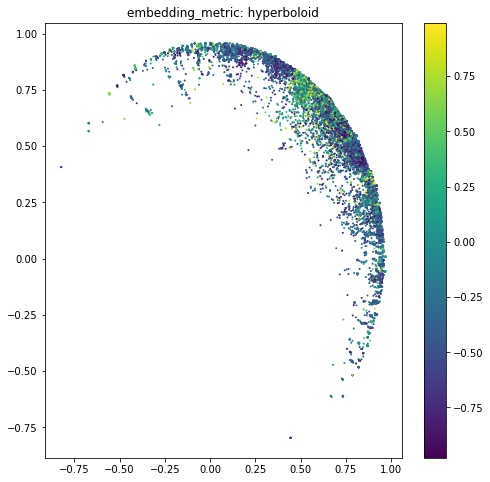

In [ ]:
plot_embedding(trained_model, projection="disk")

## Grid search

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
def grid_search(tokens, param_grid, labels=None, debug=False):
    print(f"grid search, num_grids: {len(param_grid)}, debug: {debug}...")
    
    models = []
    for i, params in enumerate(param_grid):
        print("\n", i, params)

        config = {
            "seed": params["seed"],
            # data args
            "min_df": params["min_df"],
            "vectorizer": params["vectorizer"],
            # model args
            "num_components": params["num_components"],
            "num_neighbors": params["num_neighbors"],
            "output_metric": params["output_metric"],
            "target_metric": params["target_metric"],
            "target_weight": params["target_weight"],
            "densmap": params["densmap"]
        }

        trained_model = main(config, tokens, labels)
        
        models.append(trained_model)

        if debug and i > 0: 
            break
    return models

SyntaxError: ignored

In [ ]:
def plot_embeddings(param_grid, models, labels=None):
    df_config = pd.DataFrame(list(param_grid))
    num_neighbors = df_config["num_neighbors"].unique() 
    num_cols = len(num_neighbors)

    fig, ax = plt.subplots(2, num_cols, figsize=(num_cols * 4, 8))
    for i in range(len(df_config)):
        args = df_config.iloc[i]
        row = 0 if args["vectorizer"] == "bow" else 1
        col = np.where(num_neighbors == args["num_neighbors"])[0][0]

        embedding_matrix = models[i].embedding_
        ax[row, col].scatter(
            embedding_matrix[:, 0], 
            embedding_matrix[:, 1], 
            c=labels,
            s=1
        )
        ax[row, col].set_title(f"num_neighbors: {args['num_neighbors']}")
        
        if i >= len(models) - 1:
            break

    ax[0, 0].set_ylabel("bow")
    ax[1, 0].set_ylabel("tfidf")
    plt.tight_layout()
    plt.show()

In [ ]:
param_grid = ParameterGrid(
    {
        "seed": [0],
        # data args
        "min_df": [3],
        "vectorizer": ["bow", "tfidf"],
        # model args
        "num_components": [2],
        "num_neighbors": [5, 15, 50, 100, 200],
        "output_metric": ["euclidean"], # ["euclidean", "hyperboloid", "haversine"]
        "target_metric": ["l2"],
        "target_weight": [0.5],
        "densmap": [False] # useless
    }
)

### Unsupervised UMAP

In [ ]:
models = grid_search(tokens, param_grid, labels=None, debug=False)

In [ ]:
plot_embeddings(param_grid, models, labels=cont_labels)

### Supervised UMAP

In [ ]:
sup_models = grid_search(tokens, param_grid, labels=cont_labels, debug=False)

In [ ]:
plot_embeddings(param_grid, sup_models, labels=cont_labels)